In [2]:
from google.colab import drive
import os
import pandas as pd


drive.mount('/content/drive')
# Replace with your own path

mnist_data = pd.read_csv('/content/drive/MyDrive/mnist.csv').values

Mounted at /content/drive


In [6]:
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
digits_square = digits.reshape(digits.shape[0],img_size, img_size)

In [4]:
def get_resource_usage():
    return psutil.cpu_percent(), psutil.virtual_memory().percent


In [7]:
#--------------------------------------SVM--------------------------------------------------

import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import psutil



# Resize images to (42000,14,14)
(N, H, W) = digits_square.shape

new_H = int(H / 2)
new_W = int(W / 2)
digits_square_resized_flattened = np.empty((N, new_H * new_W))

# Change the 'dtype' of digits_square because it is required by cv2
digits_square = np.array(digits_square, dtype='uint8')

for i in range(N):
    digits_square_resized_flattened[i] = cv2.resize(digits_square[i], (new_H, new_W)).flatten()

labels_reshaped = labels.reshape(-1, 1)

# Split dataset and fmatten images
X_train, X_test, y_train, y_test = train_test_split(digits_square_resized_flattened, labels_reshaped, test_size=37000, random_state=42)

X_train_flattened_scaled = scale(X_train)
X_test_flattened_scaled = scale(X_test)


# ------------------------------RandomSearch----------------------------

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Perform standard scaling
    ('svm', SVC())                 # Apply SVM
])

param_dist = {
    'svm__C': uniform(loc=0.001, scale=100),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}



random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


X_train, X_test, y_train, y_test = train_test_split(digits_square_resized_flattened, labels_reshaped, test_size=37000, random_state=42)

random_search.fit(X_train_flattened_scaled, y_train.ravel())

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'svm__C': 70.80825777960456, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}


In [8]:
# Extract best parameters and remove the 'svm__' prefix
best_params_stripped = {key.replace('svm__', ''): value for key, value in random_search.best_params_.items()}
print(best_params_stripped)
# Create a new pipeline with the best parameters

start_time = time.time()
initial_cpu_percent, initial_memory_percent = get_resource_usage()

best_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**best_params_stripped))
])

# Fit the pipeline on the training data
print(str(len(X_train))+":"+str(len(y_train.ravel())))
best_svm_pipeline.fit(X_train, y_train.ravel())

svm_training_time = time.time() - start_time

print(f"SVM Training Time: {svm_training_time} seconds")



# Obtain predictions using the pipeline to ensure consistent scaling
predicted_labels_svm_grid = best_svm_pipeline.predict(X_test)


{'C': 70.80825777960456, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
5000:5000
SVM Training Time: 1.8130600452423096 seconds


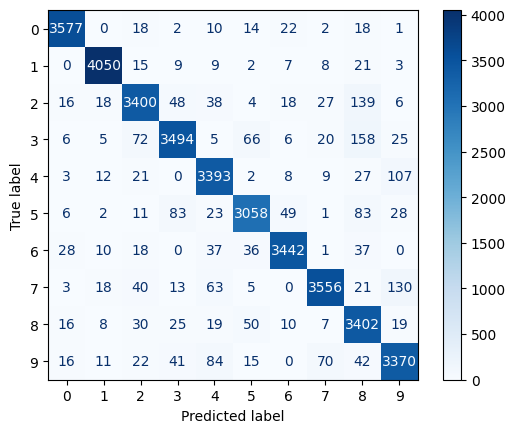

Accuracy with Random search for Best Hyper-parameters: 0.938972972972973


In [ ]:
# ------------------------------RandomSearch----------------------------
# Comfusion Matrix
cm_svm_grid = confusion_matrix(y_test, predicted_labels_svm_grid)
disp_svm_grid = ConfusionMatrixDisplay(confusion_matrix=cm_svm_grid, display_labels=best_svm_pipeline.classes_)
disp_svm_grid.plot(cmap='Blues')
plt.show()

# SVM Accuracy
accuracy_svm_grid = accuracy_score(y_test, predicted_labels_svm_grid)
print("Accuracy with Random search for Best Hyper-parameters:", accuracy_svm_grid)


In [ ]:
digits_square_resized_flattened.shape

(42000, 196)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logit Training Time: 127.99064755439758 seconds


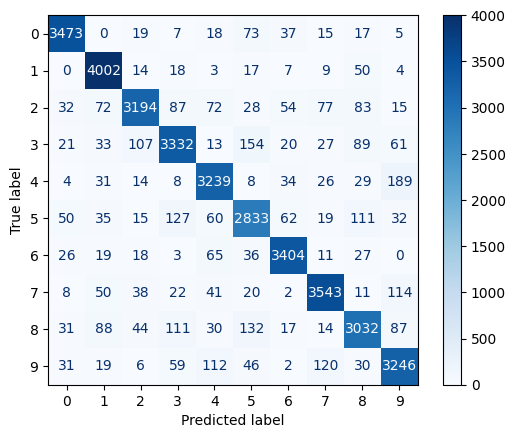

In [ ]:
#------------------------------------------------- Multinomial Logistic Regression --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression


# X_train, X_test, y_train, y_test = train_test_split(digits_square_resized_flattened, labels_reshaped, test_size=37000, random_state=42)

# X_train_flattened_scaled = scale(X_train)
# X_test_flattened_scaled = scale(X_test)

start_time = time.time()

mult_logit_model = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', max_iter=1000)
mult_logit_model.fit(X_train_flattened_scaled, y_train.ravel())

logit_training_time = time.time() - start_time


print(f"Logit Training Time: {logit_training_time} seconds")


# Predict and evaluate
predicted_labels_mult_logit_model = mult_logit_model.predict(X_test_flattened_scaled)

# Confusion Matrix
cm_mult_logit_model = confusion_matrix(y_test, predicted_labels_mult_logit_model)
disp_mult_logit_model = ConfusionMatrixDisplay(confusion_matrix=cm_mult_logit_model, display_labels=mult_logit_model.classes_)
disp_mult_logit_model.plot(cmap='Blues')
plt.show()


In [ ]:
# Multinomial logit Accuracy
accuracy_logit = accuracy_score(y_test, predicted_labels_mult_logit_model)
print("Accuracy For Multinomial Logistic Regression:", accuracy_logit)

Accuracy For Multinomial Logistic Regression: 0.8999459459459459


In [ ]:
#--------------------------------------------------------------- McNemar-BowkerStatisticalTest------------------------------------------------------------------------
from statsmodels.stats.contingency_tables import mcnemar

real_labels = y_train.ravel()

predictions_svm = predicted_labels_svm_grid  # svm predictions
predictions_logistic = predicted_labels_mult_logit_model  #  Logistic Regression predictions
y_true = real_labels  # Real labels

# contingency table for McNemar-Bowker Test
contingency_table = np.zeros((10, 10), dtype=int)

for i in range(len(y_true)):
    contingency_table[y_true[i], predictions_svm[i]] += 1
    contingency_table[y_true[i], predictions_logistic[i]] += 1

print(contingency_table)
# Run McNemar-Bowker Test
result = mcnemar(contingency_table)


print("McNemar-Bowker Test Statistic:", result.statistic)
print("P-value:", result.pvalue)

if result.pvalue < 0.05:
    print("There is a significant statistical difference")
else:
    print("There is no significant statistical difference")


[[ 94  81  65 110 109  82  70  99 130  96]
 [127 144 141 130 104  78  85  96 113 102]
 [ 90 109  90 114  87  63  80  99 103  91]
 [106 124  86 109  98  72 117 106  73  97]
 [ 83  99 108 115 101 110 113  79  73  99]
 [ 78 119  64  89 100  80  88  97  95  92]
 [ 84 136 101 115  84  81 103 134 100 118]
 [109 109 110 135  96  83 115 128 123  96]
 [104 110  89 107 102  90  82 100  87  83]
 [ 80  88 117 111 116  71  98  90 122 141]]
McNemar-Bowker Test Statistic: 81.0
P-value: 0.0017403727905944194
There is a significant statistical difference


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

# Assuming y_test, predictions_svm, and predictions_logistic are defined as:
# - y_test: true labels for the test set
# - predictions_svm: predictions from the SVM model
# - predictions_logistic: predictions from the logistic regression model

# Binary representation of correctness of predictions
correct_svm = predictions_svm == y_test.ravel()
correct_logistic = predictions_logistic == y_test.ravel()

# Constructing the 2x2 contingency table
# [model1 correct, model2 incorrect]
# [model1 incorrect, model2 correct]
contingency_table = np.array([
    [(correct_svm & correct_logistic).sum(), (correct_svm & ~correct_logistic).sum()],
    [(~correct_svm & correct_logistic).sum(), (~correct_svm & ~correct_logistic).sum()]
])

# Run McNemar's test
result = mcnemar(contingency_table, exact=False)  # Use exact=False for large samples

print("McNemar's Test Statistic:", result.statistic)
print("P-value:", result.pvalue)

# Interpret the p-value
if result.pvalue < 0.05:
    print("There is a significant statistical difference between the classifiers.")
else:
    print("There is no significant statistical difference between the classifiers.")


McNemar's Test Statistic: 729.078781512605
P-value: 1.4207358630855478e-160
There is a significant statistical difference between the classifiers.


NameError: ignored

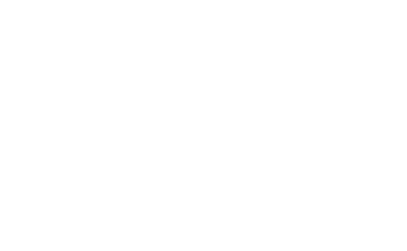

In [1]:
import matplotlib.pyplot as plt

# Assuming contingency_table is defined as in your McNemar's test code
fig, ax = plt.subplots(figsize=(5, 3))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table and place it on the axes
the_table = ax.table(cellText=contingency_table,
                     colLabels=['Correct (Mult. logit)', 'Incorrect (Mult. logit)'],
                     rowLabels=['Correct (SVM)', 'Incorrect (SVM)'],
                     cellLoc = 'center', rowLoc = 'center',
                     loc='center')

# Show the plot
plt.show()

In [ ]:
#--------------------------------------------------------Paired t-Test-----------------------------------------------------------
from scipy.stats import ttest_rel

accuracy_per_class_SVM = cm_svm_grid.diagonal() / cm_svm_grid.sum(axis=1)
accuracy_per_class_Logistic = cm_mult_logit_model.diagonal() / cm_mult_logit_model.sum(axis=1)


for i in range(len(accuracy_per_class_SVM)):
    print(f"Accuracy for Class {i}: {accuracy_per_class_SVM[i]}")
    print(f"Accuracy for Class {i}: {accuracy_per_class_Logistic[i]}")


# Perform a paired t-test
t_statistic, p_value = ttest_rel(accuracy_per_class_SVM, accuracy_per_class_Logistic)

print("Paired t-Test t-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference between the classifiers.")
else:
    print("No significant difference between the classifiers.")

Accuracy for Class 0: 0.9762554585152838
Accuracy for Class 0: 0.9478711790393013
Accuracy for Class 1: 0.9820562560620757
Accuracy for Class 1: 0.9704170708050437
Accuracy for Class 2: 0.9154550350026925
Accuracy for Class 2: 0.8599892299407647
Accuracy for Class 3: 0.9058854031630801
Accuracy for Class 3: 0.8638838475499092
Accuracy for Class 4: 0.9472361809045227
Accuracy for Class 4: 0.9042434394193188
Accuracy for Class 5: 0.9144736842105263
Accuracy for Class 5: 0.847188995215311
Accuracy for Class 6: 0.9537267941257966
Accuracy for Class 6: 0.943197561651427
Accuracy for Class 7: 0.9238763315146792
Accuracy for Class 7: 0.9204988308651598
Accuracy for Class 8: 0.9486893474623536
Accuracy for Class 8: 0.8455103179029559
Accuracy for Class 9: 0.9180059929174612
Accuracy for Class 9: 0.8842277308635249
Paired t-Test t-statistic: 4.182450805349159
P-value: 0.002367467366061136
There is a significant difference between the classifiers.


In [ ]:
#--------------------------------------------------------One-way ANOVA-----------------------------------------------------------
from scipy.stats import f_oneway

accuracy_per_class_SVM = cm_svm_grid.diagonal() / cm_svm_grid.sum(axis=1)
accuracy_per_class_Logistic = cm_mult_logit_model.diagonal() / cm_mult_logit_model.sum(axis=1)


for i in range(len(accuracy_per_class_SVM)):
    print(f"SVM accuracy for Class {i}: {accuracy_per_class_SVM[i]}" )
    print(f"Logistic regression accuracy for Class {i}: {accuracy_per_class_Logistic[i]}")



accuracies_svm = accuracy_per_class_SVM[0:9]
accuracies_logistic =accuracy_per_class_Logistic[0:9]



f_statistic, p_value = f_oneway(accuracies_svm, accuracies_logistic)

print("One-way ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference between the classifiers.")
else:
    print("No significant difference between the classifiers.")

SVM accuracy for Class 0: 0.9762554585152838
Logistic regression accuracy for Class 0: 0.9478711790393013
SVM accuracy for Class 1: 0.9820562560620757
Logistic regression accuracy for Class 1: 0.9704170708050437
SVM accuracy for Class 2: 0.9154550350026925
Logistic regression accuracy for Class 2: 0.8599892299407647
SVM accuracy for Class 3: 0.9058854031630801
Logistic regression accuracy for Class 3: 0.8638838475499092
SVM accuracy for Class 4: 0.9472361809045227
Logistic regression accuracy for Class 4: 0.9042434394193188
SVM accuracy for Class 5: 0.9144736842105263
Logistic regression accuracy for Class 5: 0.847188995215311
SVM accuracy for Class 6: 0.9537267941257966
Logistic regression accuracy for Class 6: 0.943197561651427
SVM accuracy for Class 7: 0.9238763315146792
Logistic regression accuracy for Class 7: 0.9204988308651598
SVM accuracy for Class 8: 0.9486893474623536
Logistic regression accuracy for Class 8: 0.8455103179029559
SVM accuracy for Class 9: 0.9180059929174612
Log

In [ ]:
#-----------------------------------------Mcnemar-for-each-class------------------------------------------------
from statsmodels.stats.contingency_tables import mcnemar

# Assuming y_test, predictions_svm, and predictions_logistic are defined as:
# - y_test: true labels for the test set
# - predictions_svm: predictions from the SVM model
# - predictions_logistic: predictions from the logistic regression model

# Binary representation of correctness of predictions
predictions_svm = predicted_labels_svm_grid  # svm predictions
predictions_logistic = predicted_labels_mult_logit_model  #  Logistic Regression predictions

for class_label in range(10):
        correct_svm = (predictions_svm == y_test.ravel()) & (y_test.ravel() == class_label)

        correct_logistic = (predictions_logistic == y_test.ravel()) & (y_test.ravel() == class_label)

        # Constructing the 2x2 contingency table
        # [model1 correct, model2 incorrect]
        # [model1 incorrect, model2 correct]
        contingency_table = np.array([
            [(correct_svm & correct_logistic).sum(), (correct_svm & ~correct_logistic).sum()],
            [(~correct_svm & correct_logistic).sum(), (~correct_svm & ~correct_logistic).sum()]
        ])

        # Run McNemar's test
        result = mcnemar(contingency_table, exact=False)  # Use exact=False for large samples

        print("McNemar's Test Statistic:", result.statistic)
        print("P-value for class:"+str(class_label)+"is :", result.pvalue)

        # Interpret the p-value
        if result.pvalue < 0.05:
            print("There is a significant statistical difference between the classifiers for class.",class_label)
        else:
            print("There is no significant statistical difference between the classifiers for class.",class_label)


McNemar's Test Statistic: 68.8896103896104
P-value for class:0is : 1.0413196478878748e-16
There is a significant statistical difference between the classifiers for class. 0
McNemar's Test Statistic: 26.297619047619047
P-value for class:1is : 2.9264923687908515e-07
There is a significant statistical difference between the classifiers for class. 1
McNemar's Test Statistic: 114.19836956521739
P-value for class:2is : 1.179033433305808e-26
There is a significant statistical difference between the classifiers for class. 2
McNemar's Test Statistic: 64.48009950248756
P-value for class:3is : 9.751227490471492e-16
There is a significant statistical difference between the classifiers for class. 3
McNemar's Test Statistic: 88.67045454545455
P-value for class:4is : 4.663791834171943e-21
There is a significant statistical difference between the classifiers for class. 4
McNemar's Test Statistic: 119.18289786223278
P-value for class:5is : 9.55047928798928e-28
There is a significant statistical differe